Setup Python environment first

In [176]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import sqlite3
from datetime import datetime

con = sqlite3.connect("data/calls.db")
df = pd.read_sql_query("SELECT * from calls", con)

# 1. Data Cleaning

Peek data to get clues on how to clean the data.

In [177]:
df.head()

,ID,Call Duration,Call Frequency,Financial Loss,Flagged by Carrier,Is International,Previous Contact Count,Country Prefix,Call Type,Timestamp,Device Battery,Scam Call
0,947429,-719,12,42.130000,Suspicious,Yes,1,95,Voip,2023-07-23 09:04:00,Fully Charged,Scam
1,540498,116,3,29.900000,Unlikely,Yes,0,91,Mobile,2023-09-05 20:11:00,Fully Charged,Scam
2,434243,29,16,723.460000,Very Suspicious,Yes,2,91,Voip,2023-12-16 11:03:00,Charging,Scam
3,903537,-563,4,64.287478,Unlikely,Yes,3,91,Telegram,2023-02-25 10:41:00,Fully Charged,Not Scam
4,969179,312,19,0.000000,Unlikely,Yes,0,91,Telegram,2023-11-10 15:53:00,Fully Charged,Scam


In [178]:
# setup column identifier for easy access of dataframe
id, dur, freq, loss, flagged, international, prevContactCount, country, callType, timeStamp, battery, scam = df.columns

## Duplicated Data

In [179]:
prev_count = len(df)
df = df.drop_duplicates()
new_count = len(df)
print(f"After removing duplicates, the number of rows dropped from {prev_count} to {new_count}")

After removing duplicates, the number of rows dropped from 12000 to 10000


## Unique Call ID

Check every call ID is unique.

In [180]:
len(pd.unique(df[id])) == len(df[id])

True

## Negative Call Durations

There are 2500 rows negative call durations.

In [181]:
len(df[df[dur] < 0])

2500

These negative values are most likely to be typos, so correct them to positive.

In [182]:
df.loc[df[dur] < 0, dur] = -df.loc[df[dur] < 0, dur]


## Negative Financial Losses

232 call records resulted in negative financial losses. The losses are negative because the scammer paid victim upfront in order to lure victim deeper but the victims quit the scam halfway. There is no need to fix negative financial losses.

In [183]:
len(df.loc[df[loss]<0])

232

## Invalid Categorical Data

In [184]:
categorical = [flagged, international, country, callType, battery, scam]
for cat in categorical:
    print(cat, pd.unique(df[cat]))

Flagged by Carrier ['Suspicious' 'Unlikely' 'Very Suspicious']
Is International ['Yes' 'No']
Country Prefix ['95' '91' '44' '65' 'MM' '1' '7']
Call Type ['Voip' 'Mobile' 'Telegram' 'Whats App' 'Landline' 'WhatsApp']
Device Battery ['Fully Charged' 'Charging' 'Not Charging']
Scam Call ['Scam' 'Not Scam']


Whatsapp is represented as "Whats App" or "WhatsApp" in the Call Type column. Use single representation.

In [185]:
df.loc[df[callType] == "Whats App", callType] = "Whatsapp"
df.loc[df[callType] == "WhatsApp", callType] = "Whatsapp"

Myanmar is represented as "MM" or "95" in the Country Prefix column. Use single representation.

In [186]:
df.loc[df[country] == 'MM', country] = '95'

## Null or Missing Data

Identify column with missing data

In [187]:
for col in df.columns:
    if len(df.loc[pd.isnull(df[col])]) > 0:
           print(col)

Financial Loss


Fix NaN for Financial Loss column.

In [188]:
df.loc[pd.isnull(df[loss]), loss] = 0

2376 calls resulted in financial loss but were indicated as Not Scam. These calls are most likely the result of breach of agreements which involve some upfront payment. No need to fix.

In [189]:
len(df.loc[df[scam] == "Not Scam"].loc[df[loss] > 0])

2376

## Convert timestamp to datetime

The timestamp is stored as a string. By converting it into a date time object, it is alot more convenient to process the data later.

In [190]:
for r in range(len(df)):
    d = datetime.strptime(df.loc[r, [timeStamp]][timeStamp], '%Y-%m-%d %H:%M:%S')
    df.loc[r, [timeStamp]] = d

# 2. Exploratory Analysis and Data Visualisation

## Summary of Dataset

Each record has a unique identifier and consists of 4 numerical variables, 1 timestamp variable and 5 categorical variables.


In [191]:
df[[dur, freq, loss, prevContactCount]].describe()

,Call Duration,Call Frequency,Financial Loss,Previous Contact Count
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,218.616900,10.653800,87.317890,1.855000
std,213.780471,5.841212,185.619696,1.769545
min,19.000000,2.000000,-896.400000,0.000000
25%,42.000000,6.000000,0.000000,0.000000
50%,120.000000,9.000000,0.000000,1.000000
75%,318.000000,15.000000,76.474018,3.000000
max,822.000000,27.000000,1055.440000,8.000000


The categorical variables are Flagged, International, Country Prefix, Call Type, Device Battery and Scam Call. A chi-square test was performed to find out if these categorical variables are independent against Scam variable at 1% significance. As expected, device battery status is independent of the scam variable. When performing classification, the variable Device Battery can be ignored.

In [215]:
alpha = 0.01
pvalues = []
pless = []
index = []
conclusion = []
for cat in categorical:
    if cat != scam:        
        crosstab = pd.crosstab(df[cat], df[scam])                
        res = stats.chi2_contingency(crosstab)
        pvalues.append(res.pvalue)
        pless.append(res.pvalue < alpha)
        if res.pvalue < alpha:
            conclusion.append("Not independent")
        else:
            conclusion.append("Independent")
        index.append(cat)
pd.DataFrame({"Categorical Variable": index, "p-value": pvalues, f"p < {alpha}": pless, "Conclusion": conclusion})

,Categorical Variable,p-value,p < 0.01,Conclusion
0,Flagged by Carrier,2.799915e-93,True,Not independent
1,Is International,2.874432e-10,True,Not independent
2,Country Prefix,5.247931e-176,True,Not independent
3,Call Type,1.222492e-66,True,Not independent
4,Device Battery,9.058516e-01,False,Independent


## What time are the scammers calling?

The scammers are calling every day, so no distinct pattern is found.

<Axes: >

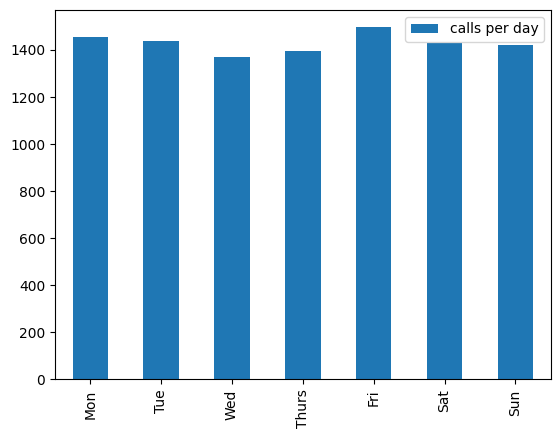

In [209]:
weekdays = [0]*7
index = ["Mon", "Tue", "Wed", "Thurs", "Fri", "Sat", "Sun"]
for d in df[timeStamp]:
    weekdays[d.weekday()] += 1
pd.DataFrame({"calls per day":weekdays}, index=index).plot.bar()

However, there is a spike in scam calls during the time periods 1000-1200, 2000-2200. It is also surprising to see that scam calls also take place during the wee hours [0000-0600]

<Axes: >

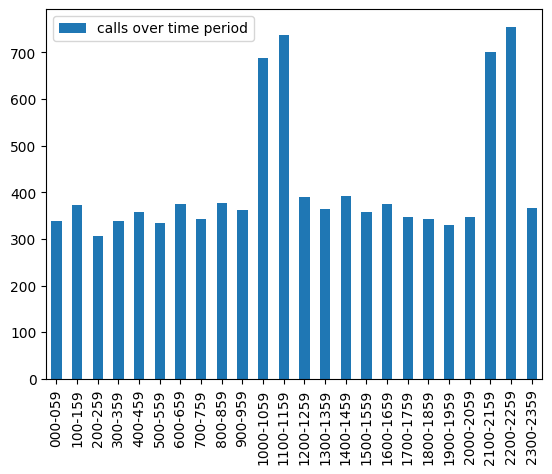

In [195]:
hours = [0]*24
index = [f"{h}00-{h}59" for h in range(24)]
for d in df[timeStamp]:
    hours[d.hour] += 1
pd.DataFrame({"calls over time period":hours}, index=index).plot.bar()

## Imbalanced Dataset

The dataset is not balanced. 37.5% of the records are scam while 62.5% are not scam. This will affect the accuracy of the classifier algorithms. A new training dataset has to be generated from this dataset when performing classification.

In [196]:
total = len(df)
scams = len(df.loc[df[scam] == "Scam"])
notscams = len(df.loc[df[scam] == "Not Scam"])
print(f"{scams/total*100:.1f}% of the call records are scams")
print(f"{notscams/total*100:.1f}% of the call records are not scams")

37.5% of the call records are scams
62.5% of the call records are not scams


## How effective is carrier's flagging?

In [197]:
total = len(df.loc[df[flagged] == "Unlikely"])
actual = len(df.loc[df[flagged] == "Unlikely"].loc[df[scam] == "Scam"])
print(f"False negative rate is {actual/total*100:.1f}%")

False negative rate is 32.0%


The financial loss due to false negativity of the carrier's flagging is just as big as the financial losses of the other categories. Hence, flagging by the carrier is not an effective measure.

<Axes: >

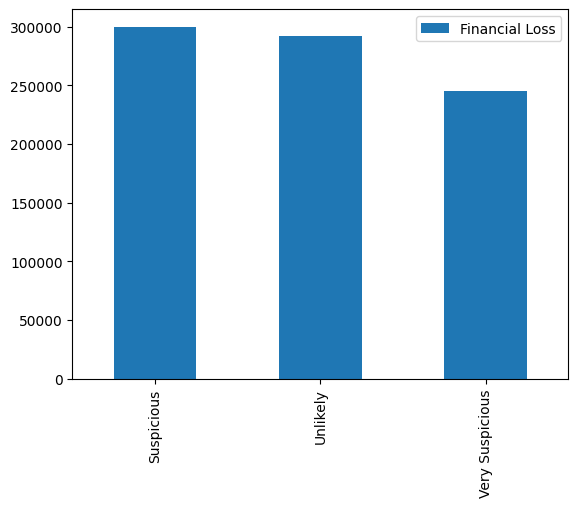

In [198]:
finloss, index = [], []
dfScam = df.loc[df[scam] == "Scam"]
for cat in pd.unique(df[flagged]):
    dfScamCat = dfScam.loc[df[flagged] == cat]
    # need to account for negative financial losses
    total = dfScamCat.loc[df[loss]>0,loss].sum() - dfScamCat.loc[df[loss]<0, loss].sum()
    finloss.append(total)
    index.append(cat)
pd.DataFrame({loss: finloss}, index=index).plot.bar()

## Reverse Scamming

Negative financial loss happens when the scammer transfers money to the victim in order to lure the victim deeper but the victim realises the scam and profited by exit. From the boxplot below, the median of the negative financial loss decreases as the number of previous contacts increases until 3, then decreases. If a victim wants to profit off a scammer, he could try to contact the scammer up to 4 times [including 3 previous contacts].

<Axes: title={'center': 'Financial Loss'}, xlabel='Previous Contact Count'>

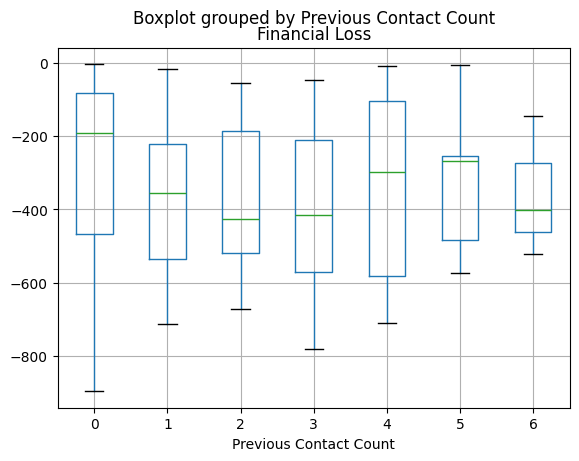

In [199]:
dfScam.loc[dfScam[loss]<0].boxplot(loss, prevContactCount)